In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from configparser import ConfigParser
from tqdm import tqdm
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random
import numpy as np
import shutil
# import faiss
from openai import OpenAI
import os
import base64
import json
from io import BytesIO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report,precision_recall_fscore_support
import json

# Data

In [76]:
# train_dir = "/content/drive/MyDrive/Binary_classification_using_LLMs/var_normal merged lesion train_test dataset (1000)/train"
# test_dir =  "/content/drive/MyDrive/Binary_classification_using_LLMs/var_normal merged lesion train_test dataset (1000)/test"

train_dir = "/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/train"
test_dir =  "/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/test"

In [77]:
os.listdir(train_dir)

['lesion_train_df.xlsx',
 'var_train_df.xlsx',
 'normal_train_df.xlsx',
 'lesion',
 'variation in normal',
 'normal']

In [78]:
def get_data(root_directory):
    image_text_pairs = []
    # for label in os.listdir(root_directory):
    for label in ["lesion","normal","variation in normal"]:
      label_dir = os.path.join(root_directory, label)
      if os.path.isdir(label_dir):
        # Iterate through each image in the label directory
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            # Check if the path is a file (to avoid subdirectories)
            if os.path.isfile(image_path):
                # Add the image path and label to the list
                if label == 'variation in normal':
                    # image_text_pairs.append((image_path, 'normal'))
                    image_text_pairs.append((image_path, 'lesion'))
                    continue
                image_text_pairs.append((image_path, label))
    return image_text_pairs

In [79]:
test_df = pd.DataFrame(get_data(test_dir), columns=['image path','label'])
test_df

,image path,label
0,/content/drive/MyDrive/Binary_classification_u...,lesion
1,/content/drive/MyDrive/Binary_classification_u...,lesion
2,/content/drive/MyDrive/Binary_classification_u...,lesion
3,/content/drive/MyDrive/Binary_classification_u...,lesion
4,/content/drive/MyDrive/Binary_classification_u...,lesion
...,...,...
303,/content/drive/MyDrive/Binary_classification_u...,lesion
304,/content/drive/MyDrive/Binary_classification_u...,lesion
305,/content/drive/MyDrive/Binary_classification_u...,lesion
306,/content/drive/MyDrive/Binary_classification_u...,lesion


from matplotlib import pyplot as plt
import seaborn as sns
test_df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [80]:
train_df = pd.DataFrame(get_data(train_dir), columns=['image path','label'])
train_df

,image path,label
0,/content/drive/MyDrive/Binary_classification_u...,lesion
1,/content/drive/MyDrive/Binary_classification_u...,lesion
2,/content/drive/MyDrive/Binary_classification_u...,lesion
3,/content/drive/MyDrive/Binary_classification_u...,lesion
4,/content/drive/MyDrive/Binary_classification_u...,lesion
...,...,...
720,/content/drive/MyDrive/Binary_classification_u...,lesion
721,/content/drive/MyDrive/Binary_classification_u...,lesion
722,/content/drive/MyDrive/Binary_classification_u...,lesion
723,/content/drive/MyDrive/Binary_classification_u...,lesion


# Data Processor

In [49]:
def to_base64(path):
    with open(path, 'rb') as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode('utf-8')
    return image_base64

class Processor:
    def __init__(self, lesion_image_list,normal_image_list, test_image_path,normal_cot_dict,lesion_cot_dict, max_size=200):
        if normal_image_list is None:
            normal_image_list = []
        self.lesion_image_list = lesion_image_list
        self.normal_image_list = normal_image_list
        self.normal_cot_dict = normal_cot_dict
        self.lesion_cot_dict = lesion_cot_dict
        self.max_size = max_size
        self.test_image = test_image_path
        # self.lesion_descriptions = get_lesion_description()
        self.messages = None

    def get_image_data(self, img_path):
        return self.resize_and_convert_to_base64(img_path)

    def resize_and_convert_to_base64(self, image_path):
        size = self.max_size
        # Open the image file
        with Image.open(image_path) as img:
            # Check the size of the image
            width, height = img.size

            # Resize if either dimension is greater than 800 pixels
            if width > size or height > size:
                # Determine the new size while maintaining the aspect ratio
                if width > height:
                    new_width = size
                    new_height = int((size / width) * height)
                else:
                    new_height = size
                    new_width = int((size / height) * width)

                # Resize the image
                img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

            # Convert the image to base64
            buffered = BytesIO()
            img.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

            return img_base64

    def get_content(self):
        content_list = [{
            "type": "text",
            "text":"""Here are some images and their respective thought process and reasons to classify them into their output classes.
                      Please act as an image classifier while following a similar thought process and classify the last image as either "lesion" or "normal".
                      Your response should be a JSON object with the following keys:
                      - "description"
                      - "output"

                      Example response:
                      {
                        "description": A detailed thought process explaining the reasoning behind the classification,
                        "output": The final classification, which should be either "lesion" or "normal"
                      }

                      Respond only with the JSON object. Do not write any explanations, comments, or plain text outside the JSON object."""
        }]
        for img_path in self.lesion_image_list:
            content_list.append(
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{self.get_image_data(img_path)}"
                    }
                }
            )
            # # entire description
            # content_list.append(
            #     {"type": "text", "text": self.lesion_descriptions[str(img_num)]}
            # )

            # labeled only as Leukoplakia
            content_list.append(
                {"type": "text", "text": lesion_cot_dict[img_path]}
            )
            content_list.append(
                {"type": "text", "text": "Output:lesion"}
            )
        for img_path in self.normal_image_list:
            content_list.append(
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{self.get_image_data(img_path)}"
                    }
                }
            )
            content_list.append(
                {"type": "text", "text": normal_cot_dict[img_path]}
            )
            content_list.append(
                {"type": "text", "text": "Output:normal"}
            )
        return content_list
    def get_message(self):
        self.messages = [
            {"role": "user", "content": self.get_content()},
            {"role": "user", "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{self.get_image_data(self.test_image)}"
                    }
                }]
             }
        ]

# Prediction

In [59]:
# load COT dict
# with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/COT/var as normal cot(template any one of random 10).json", 'r') as file:
with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/COT/var as lesion cot(template any one of random 10).json", 'r') as file:
    var_normal_cot_dict = json.load(file)



with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/COT/normal cot(template any one of random 10).json", 'r') as file:
    normal_cot_dict = json.load(file)
    # normal_cot_dict.update(var_normal_cot_dict)


with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/COT/lesion cot(template any one of random 10).json", 'r') as file:
    lesion_cot_dict = json.load(file)
    lesion_cot_dict.update(var_normal_cot_dict)

In [60]:
client = OpenAI(api_key = "sk-5MnwpVvFZ_HWVNnF4hxAznHFqSTyu2FOmOl4FiXrXnT3BlbkFJ0v7MT3OHej4IkO-4Gkml1fWiqmLcxBWvWItFtkR4oA")


def predict(lesion_image_list,normal_image_list,test_image_path,normal_cot_dict,lesion_cot_dict):
    image_processor = Processor(lesion_image_list,
                                normal_image_list,
                                test_image_path,
                                normal_cot_dict,
                                lesion_cot_dict)

    image_processor.get_message()
    messages = image_processor.messages

    response = client.chat.completions.create(
        model='gpt-4o-2024-11-20',
        messages=messages,
        temperature=0.0,
        max_tokens=200
    )

    return response.choices[0].message.content

In [69]:
num_images = 5
normal_image_list = random.sample(list(normal_cot_dict.keys()),num_images)
lesion_image_list = random.sample(list(lesion_cot_dict.keys()),num_images)
lesion_image_list

['/content/drive/MyDrive/Binary_classification_using_LLMs/BUCCAL MUCOSA (1000)/lesion/SMITA00196_R_RB.jpg',
 '/content/drive/MyDrive/Binary_classification_using_LLMs/BUCCAL MUCOSA (1000)/variation in normal/SMITA00543_R_LB.jpg',
 '/content/drive/MyDrive/Binary_classification_using_LLMs/BUCCAL MUCOSA (1000)/lesion/SMITA00540_R_RB.jpg',
 '/content/drive/MyDrive/Binary_classification_using_LLMs/BUCCAL MUCOSA (1000)/variation in normal/SMITA00369_R_RB.jpg',
 '/content/drive/MyDrive/Binary_classification_using_LLMs/BUCCAL MUCOSA (1000)/lesion/SMITA00216_W_RB.jpeg']

In [55]:
test_image_path = test_df["image path"][0]
test_image_path

'/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/test/lesion/SMITA00214_W_RB2.jpeg'

In [19]:
test_image_path[100:]

'lesion/SMITA00214_W_RB2.jpeg'

In [20]:
# image_processor = Processor(lesion_image_list,
#                                 normal_image_list,
#                                 test_image_path,
#                                 normal_cot_dict,
#                                 lesion_cot_dict)

# image_processor.get_message()
# messages = image_processor.messages

In [81]:
# test_image_list = test_df["image path"]

max_size = 200
num_examples = 5

results = {}

num_runs = 1

for run in range(num_runs):
  print(f"Run {run+1} of {num_runs}")
  results[f"Run{run+1}"] = {}
  for idx in tqdm(test_df.index):
  # for idx in tqdm(range(10)):
      expectation = test_df["label"][idx]
      query_image_path = test_df["image path"][idx]
      normal_img_list = random.sample(list(normal_cot_dict.keys()),num_examples)
      lesion_img_list = random.sample(list(lesion_cot_dict.keys()),num_examples)
      test_image_name = query_image_path[100:]
      # print('_________________________________')
      prediction = predict(lesion_img_list,
                                normal_img_list,
                                query_image_path,
                                normal_cot_dict,
                                lesion_cot_dict
                          )

      results[f"Run{run+1}"][test_image_name] = {
          "query_image_path": query_image_path,
          "expectation": expectation,
          "prediction": prediction,
      }
  # Save a checkpoint after each run with a descriptive filename
  checkpoint_path = f"/content/drive/MyDrive/Binary_classification_using_LLMs/COT/Results/Result_after_run_{run + 1}(updated data)(var merged lesion_).json"
  with open(checkpoint_path, "w") as outfile:
      json.dump(results, outfile)
  print(f"Checkpoint saved. Data available up to Run {run + 1}")

Run 1 of 1


100%|██████████| 308/308 [26:48<00:00,  5.22s/it]

Checkpoint saved. Data available up to Run 1


In [30]:
results

{'Run1': {'lesion/SMITA00214_W_RB2.jpeg': {'query_image_path': '/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/test/lesion/SMITA00214_W_RB2.jpeg',
   'expectation': 'lesion',
   'prediction': '```json\n{\n  "description": "Upon examining the right buccal mucosa, we observe a white, brown to black area with not well-demarcated borders and a smooth texture. The non-scrappable nature of the area further supports the conclusion that this is a lesion.",\n  "output": "lesion"\n}\n```'},
  'lesion/SMITA00272_W_LB.jpeg': {'query_image_path': '/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/test/lesion/SMITA00272_W_LB.jpeg',
   'expectation': 'lesion',
   'prediction': '```json\n{\n  "description": "Upon examining the left buccal mucosa, there is a white, brown to black discoloration with not well-demarcated margins and a wrinkled surface texture. The non-scrappable nature of the area supports the con

# Results

In [3]:
# with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/COT/Results/Result_after_run_0(no_var).json", 'r') as file:
#     results = json.load(file)

# with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/COT/Results/Result_after_run_{1}.json", 'r') as file:
#     results = json.load(file)

with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/COT/Results/Result_after_run_{1}(updated data)(no var).json", 'r') as file:
    results = json.load(file)


Processing images for Run1: 100%|██████████| 252/252 [00:00<00:00, 123838.85it/s]


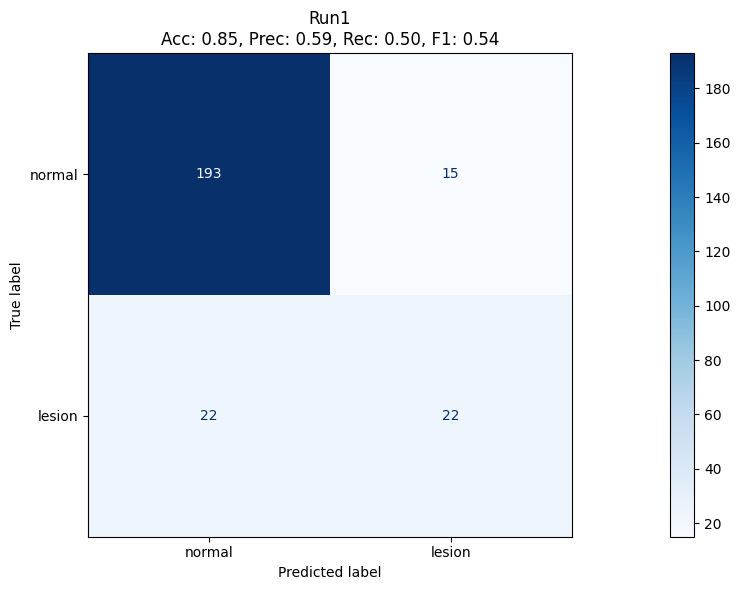


Metrics for Run1:
Accuracy: 0.85
Precision: 0.59
Recall: 0.50
F1 Score: 0.54

False Negatives for Run1:
Image: lesion/SMITA00176_W_RB.jpg, Actual: lesion, Predicted: normal, Description: 
Image: lesion/CHCI_93.jpg, Actual: lesion, Predicted: normal, Description: 
Image: lesion/SMITA00326_W_LB.jpg, Actual: lesion, Predicted: normal, Description: 
Image: lesion/SMITA000249_R_RB.jpeg, Actual: lesion, Predicted: normal, Description: 
Image: lesion/SMITA00273_W_LB.jpg, Actual: lesion, Predicted: normal, Description: 
Image: lesion/SMITA00504_R_RB.jpg, Actual: lesion, Predicted: normal, Description: 
Image: lesion/SMITA00208_R_LB.jpeg, Actual: lesion, Predicted: normal, Description: 
Image: lesion/SMITA00052_R_RB.jpg, Actual: lesion, Predicted: normal, Description: 
Image: lesion/SMITA00261_R_RB2.jpeg, Actual: lesion, Predicted: normal, Description: 
Image: lesion/SMITA00108_R_LB.jpg, Actual: lesion, Predicted: normal, Description: 
Image: lesion/SMITA00275_W_LB.jpg, Actual: lesion, Predict

In [4]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# Define class mappings
class_mapping = {"normal": 0, "lesion": 1}

# Prepare a figure for subplots
num_runs = len(results)
fig, axes = plt.subplots(1, num_runs, figsize=(20 * num_runs, 6), sharey=True)

metrics = {}
false_negatives = {}  # Dictionary to store false negatives

# Function to extract the "output" value from the prediction string
def extract_output(prediction):
    # Remove the markdown code block syntax (```json and ```)
    prediction = prediction.strip().replace('```json\n', '').replace('```', '')
    # Parse the JSON string
    prediction_dict = json.loads(prediction)
    # Return the "output" value
    return prediction_dict['output']

# Process results for each run
for idx, (run_name, run_data) in enumerate(results.items()):
    # Initialize lists for actual and prediction values
    actual = []
    prediction = []
    unknown_classes = []
    metrics[run_name] = {}
    false_negatives[run_name] = {}  # Dictionary to store false negatives for this run

    # Process each image in the run
    for img, data in tqdm(run_data.items(), desc=f"Processing images for {run_name}"):
        actual_class = data["expectation"]
        pred_class = extract_output(data["prediction"]).lower().strip('"')  # Extract output from JSON

        if pred_class not in class_mapping:
            unknown_classes.append((img, actual_class, pred_class))
            print(f"Unknown class in prediction: {pred_class}")
            continue

        else:
            pred_label = class_mapping[pred_class]
            prediction.append(pred_label)
            actual_label = class_mapping[actual_class]
            actual.append(actual_label)

            # Check for false negatives
            if actual_class == "lesion" and pred_class == "normal":
                false_negatives[run_name][img] = {
                    "actual": actual_class,
                    "predicted": pred_class,
                    "description": data.get("description", "")  # Add description if available
                }

    # Compute metrics
    accuracy = accuracy_score(actual, prediction)
    precision = precision_score(actual, prediction, average='binary', pos_label=class_mapping["lesion"])
    recall = recall_score(actual, prediction, average='binary', pos_label=class_mapping["lesion"])
    f1 = f1_score(actual, prediction, average='binary', pos_label=class_mapping["lesion"])

    metrics[run_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "unknown_classes": unknown_classes
    }

    # Compute confusion matrix
    matrix = confusion_matrix(actual, prediction)

    # Plot confusion matrix in a subplot
    ax = axes[idx] if num_runs > 1 else axes
    cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(class_mapping.keys()))
    cm_display.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(
        f"{run_name}\n"
        f"Acc: {accuracy:.2f}, Prec: {precision:.2f}, Rec: {recall:.2f}, F1: {f1:.2f}"
    )

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Print metrics
for run_name, metric_values in metrics.items():
    print(f"\nMetrics for {run_name}:")
    print(f"Accuracy: {metric_values['accuracy']:.2f}")
    print(f"Precision: {metric_values['precision']:.2f}")
    print(f"Recall: {metric_values['recall']:.2f}")
    print(f"F1 Score: {metric_values['f1']:.2f}")
    if metric_values["unknown_classes"]:
        print(f"Unknown classes: {metric_values['unknown_classes']}")

# Print false negatives
for run_name, fn_data in false_negatives.items():
    print(f"\nFalse Negatives for {run_name}:")
    for img, details in fn_data.items():
        print(f"Image: {img}, Actual: {details['actual']}, Predicted: {details['predicted']}, Description: {details['description']}")

In [8]:
fn_dict.keys()

dict_keys(['/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/test/lesion/SMITA00176_W_RB.jpg', '/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/test/lesion/CHCI_93.jpg', '/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/test/lesion/SMITA00326_W_LB.jpg', '/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/test/lesion/SMITA000249_R_RB.jpeg', '/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/test/lesion/SMITA00273_W_LB.jpg', '/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/test/lesion/SMITA00504_R_RB.jpg', '/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on distribution/test/lesion/SMITA00208_R_LB.jpeg', '/content/drive/MyDrive/Binary_classification_using_LLMs/train test split based on d

In [5]:
fn_dict = {}
for i in false_negatives['Run1'].keys():
  query_image_path = results['Run1'][i]['query_image_path']
  description = results['Run1'][i]['prediction']
  fn_dict[query_image_path] = description

In [7]:
import textwrap
def plot_images_with_descriptions(image_dict,max_line_length=30):
    # selected_items = random.sample(list(image_dict.items()), num_images)
    sliced_dict = image_dict

    num_images = len(sliced_dict)

    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))  # 2 columns: one for image, one for text

    if num_images == 1:
        axes = [axes]  # Ensure axes is a list even if there's only one image

    for i, (image_path, description) in enumerate(sliced_dict.items()):
        img = Image.open(image_path)

        # Plot the image in the first column
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')  # Hide the axes

        # Wrap the text to avoid overlapping
        wrapped_text = textwrap.fill(description, width=max_line_length)  # Wrap text to `max_line_length` characters per line

        # Display the wrapped text in the second column
        axes[i, 1].text(0.5, 0.5, wrapped_text, fontsize=12, ha='center', va='center', wrap=True)
        axes[i, 1].axis('off')  # Hide the axes

    plt.tight_layout()
    plt.show()


plot_images_with_descriptions(fn_dict)

Output hidden; open in https://colab.research.google.com to view.

Processing images for Run1: 100%|██████████| 308/308 [00:00<00:00, 70400.31it/s]


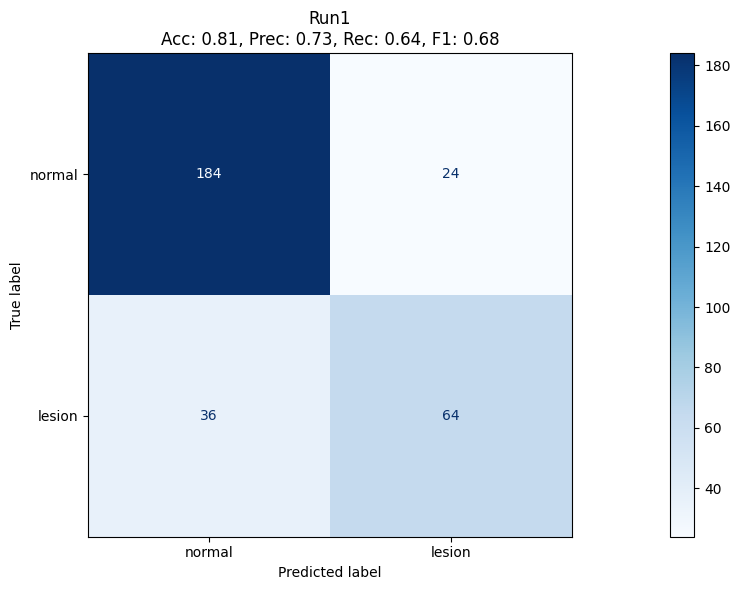


Metrics for Run1:
Accuracy: 0.81
Precision: 0.73
Recall: 0.64
F1 Score: 0.68


In [84]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# Define class mappings
class_mapping = {"normal": 0, "lesion": 1}

# Prepare a figure for subplots
num_runs = len(results)
fig, axes = plt.subplots(1, num_runs, figsize=(20 * num_runs, 6), sharey=True)

metrics = {}

# Function to extract the "output" value from the prediction string
def extract_output(prediction):
    # Remove the markdown code block syntax (```json and ```)
    prediction = prediction.strip().replace('```json\n', '').replace('```', '')
    # Parse the JSON string
    prediction_dict = json.loads(prediction)
    # Return the "output" value
    return prediction_dict['output']

# Process results for each run
for idx, (run_name, run_data) in enumerate(results.items()):
    # Initialize lists for actual and prediction values
    actual = []
    prediction = []
    unknown_classes = []
    metrics[run_name] = {}

    # Process each image in the run
    for img, data in tqdm(run_data.items(), desc=f"Processing images for {run_name}"):
        actual_class = data["expectation"]
        pred_class = extract_output(data["prediction"]).lower().strip('"')  # Extract output from JSON

        if pred_class not in class_mapping:
            unknown_classes.append((img, actual_class, pred_class))
            print(f"Unknown class in prediction: {pred_class}")
            continue

        else:
            pred_label = class_mapping[pred_class]
            prediction.append(pred_label)
            actual_label = class_mapping[actual_class]
            actual.append(actual_label)

    # Compute metrics
    accuracy = accuracy_score(actual, prediction)
    precision = precision_score(actual, prediction, average='binary', pos_label=class_mapping["lesion"])
    recall = recall_score(actual, prediction, average='binary', pos_label=class_mapping["lesion"])
    f1 = f1_score(actual, prediction, average='binary', pos_label=class_mapping["lesion"])

    metrics[run_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "unknown_classes": unknown_classes
    }

    # Compute confusion matrix
    matrix = confusion_matrix(actual, prediction)

    # Plot confusion matrix in a subplot
    ax = axes[idx] if num_runs > 1 else axes
    cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(class_mapping.keys()))
    cm_display.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(
        f"{run_name}\n"
        f"Acc: {accuracy:.2f}, Prec: {precision:.2f}, Rec: {recall:.2f}, F1: {f1:.2f}"
    )

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Print metrics
for run_name, metric_values in metrics.items():
    print(f"\nMetrics for {run_name}:")
    print(f"Accuracy: {metric_values['accuracy']:.2f}")
    print(f"Precision: {metric_values['precision']:.2f}")
    print(f"Recall: {metric_values['recall']:.2f}")
    print(f"F1 Score: {metric_values['f1']:.2f}")
    if metric_values["unknown_classes"]:
        print(f"Unknown classes: {metric_values['unknown_classes']}")

In [ ]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import pandas as pd
import xlsxwriter

# Define class mappings
class_mapping = {"normal": 1,"lesion": 0}

# Prepare an Excel writer
output_file = "/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_after_run_1_classification_results_with_paths.xlsx"
writer = pd.ExcelWriter(output_file, engine="xlsxwriter")

# Process results for each run
for run_name, run_data in results.items():
    print(f"Processing {run_name}...")

    # Initialize lists for actual, prediction, and misclassification
    actual = []
    prediction = []
    false_positives = []
    false_negatives = []
    unknown_classes = []

    # Process each image
    for img_path, data in tqdm(run_data.items(), desc=f"Processing images for {run_name}"):
        actual_class = data["expectation"]
        pred_class = data["prediction"]
        query_image_path = data["query_image_path"]

        if pred_class not in class_mapping or actual_class not in class_mapping:
            unknown_classes.append((query_image_path, actual_class, pred_class))
            continue

        actual_label = class_mapping[actual_class]
        pred_label = class_mapping[pred_class]
        actual.append(actual_label)
        prediction.append(pred_label)

        # Classify misclassifications
        if actual_label != pred_label:
            if pred_label == class_mapping["lesion"]:
                false_positives.append(query_image_path)  # Predicted lesion, but actual is normal
            else:
                false_negatives.append(query_image_path)  # Predicted normal, but actual is lesion

    # Save false positives and false negatives to a DataFrame
    misclass_df = pd.DataFrame({
        "False Positives (Image Path)": false_positives + [""] * (len(false_negatives) - len(false_positives)),
        "False Negatives (Image Path)": false_negatives + [""] * (len(false_positives) - len(false_negatives))
    })
    misclass_df.to_excel(writer, sheet_name=f"{run_name}_Misclassifications", index=False)

    # Save unknown classes to a DataFrame
    unknown_df = pd.DataFrame(unknown_classes, columns=["Image Path", "Expectation", "Prediction"])
    if not unknown_df.empty:
        unknown_df.to_excel(writer, sheet_name=f"{run_name}_Unknown", index=False)

# Save the Excel file
writer.close()
print(f"Results saved to {output_file}.")

Processing Run1...


Processing images for Run1: 100%|██████████| 311/311 [00:00<00:00, 70650.95it/s]

Results saved to /content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_after_run_1_classification_results_with_paths.xlsx.
